In [1]:
# Genetic Algorithm for Feature Selection using Log Loss (H/D/A prediction)
# - Reads features_all_seasons.csv
# - Derives H/D/A from home_goals vs away_goals
# - Uses LogisticRegression and log loss as GA fitness (lower is better)
# - Avoids leakage by excluding home_goals/away_goals from features
# - Saves GA history and best subset to /mnt/data/ga_feature_selection_outputs

In [ ]:
import os
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


### Config


In [3]:


CSV_PATH = "../data/output/features_all_seasons.csv"  # change if needed


# Output folder
OUT_DIR = "/data/ga_feature_selection_outputs"

In [4]:
# GA hyperparameters
population_size = 30
generations = 15
crossover_rate = 0.8
mutation_rate = 0.05
tournament_size = 3
random_seed = 123


In [5]:
df = pd.read_csv(CSV_PATH)
df.head()


,fixture_id,date_utc,home_team_id,home_team,away_team_id,away_team,home_goals,away_goals,season,pre_xG_home,...,away_form_points,home_win_streak,away_win_streak,rest_days_home,rest_days_away,h2h_home_wins,h2h_away_wins,key_players_missing_home,key_players_missing_away,match_importance
0,1378969,2025-08-15 19:00:00,40,Liverpool,35,Bournemouth,4,2,2025,1.483607,...,9.0,NaN,NaN,NaN,NaN,0,0,0,0,1.0
1,1378970,2025-08-16 11:30:00,66,Aston Villa,34,Newcastle,0,0,2025,1.483607,...,9.0,NaN,NaN,NaN,NaN,0,0,0,0,1.0
2,1378971,2025-08-16 14:00:00,51,Brighton,36,Fulham,1,1,2025,1.483607,...,9.0,NaN,NaN,NaN,NaN,0,0,0,0,1.0
3,1378973,2025-08-16 14:00:00,746,Sunderland,48,West Ham,3,0,2025,1.483607,...,6.0,NaN,NaN,NaN,NaN,0,0,0,0,1.0
4,1378974,2025-08-16 14:00:00,47,Tottenham,44,Burnley,3,0,2025,1.483607,...,3.0,NaN,NaN,NaN,NaN,0,0,0,0,1.0


### Load & prepare data

In [34]:
# Derive H/D/A target from goals
def derive_result(row):
    if pd.isna(row["home_goals"]) or pd.isna(row["away_goals"]):
        return np.nan
    if row["home_goals"] > row["away_goals"]:
        return "H"
    elif row["home_goals"] < row["away_goals"]:
        return "A"
    else:
        return "D"


if "home_goals" not in df.columns or "away_goals" not in df.columns:
    raise ValueError(
        "CSV must contain 'home_goals' and 'away_goals' to derive H/D/A target."
    )

df["result_HDA"] = df.apply(derive_result, axis=1)
print("Result distribution:\n", df["result_HDA"].value_counts(dropna=False))

Result distribution:
 result_HDA
H    60
A    38
D    24
Name: count, dtype: int64


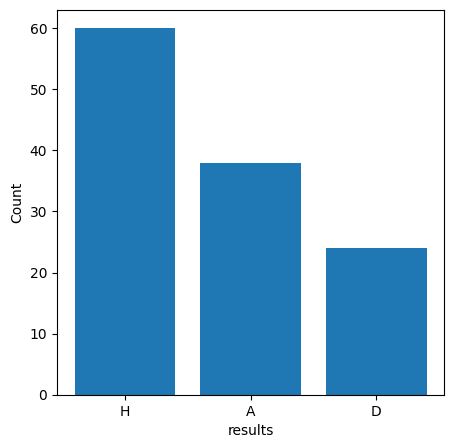

In [35]:
counts = df["result_HDA"].value_counts()

plt.figure(figsize=(5, 5))
plt.bar(counts.index, counts.values)
plt.xlabel('results')
plt.ylabel('Count')
plt.show()

array([[<Axes: title={'center': 'fixture_id'}>,
        <Axes: title={'center': 'home_team_id'}>,
        <Axes: title={'center': 'away_team_id'}>,
        <Axes: title={'center': 'home_goals'}>,
        <Axes: title={'center': 'away_goals'}>],
       [<Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'pre_xG_home'}>,
        <Axes: title={'center': 'pre_xG_away'}>,
        <Axes: title={'center': 'home_xG_avg'}>,
        <Axes: title={'center': 'away_xG_avg'}>],
       [<Axes: title={'center': 'home_xGA_avg'}>,
        <Axes: title={'center': 'away_xGA_avg'}>,
        <Axes: title={'center': 'home_team_rating'}>,
        <Axes: title={'center': 'away_team_rating'}>,
        <Axes: title={'center': 'home_form_points'}>],
       [<Axes: title={'center': 'away_form_points'}>,
        <Axes: title={'center': 'home_win_streak'}>,
        <Axes: title={'center': 'away_win_streak'}>,
        <Axes: title={'center': 'rest_days_home'}>,
        <Axes: title={'center': 'rest_d

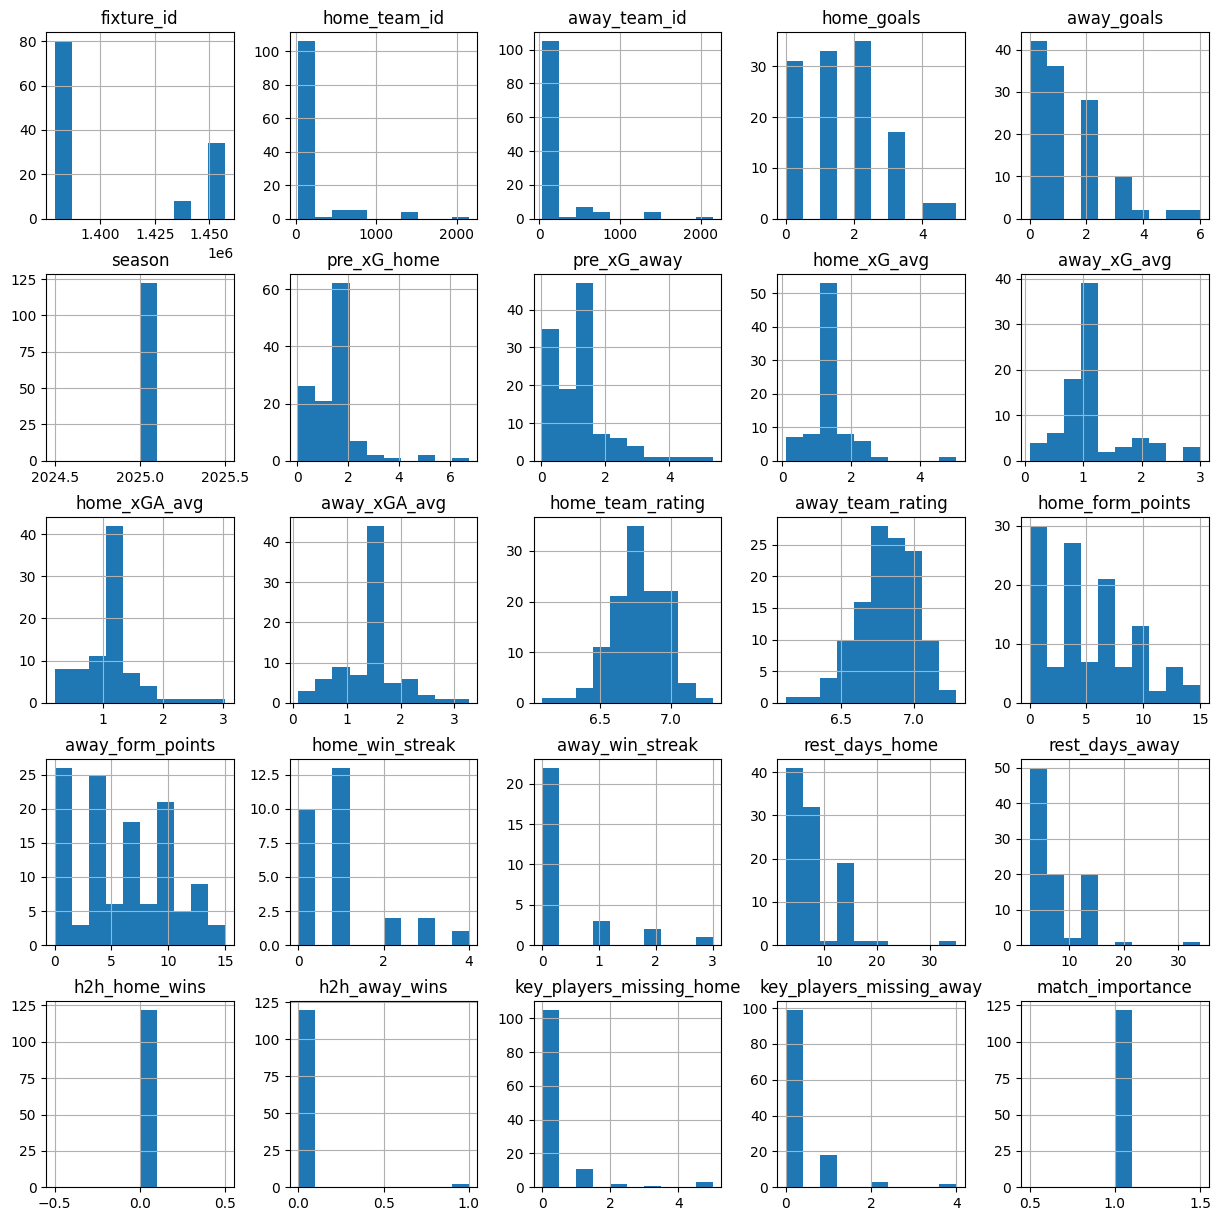

In [36]:
df.hist(figsize=(15, 15))

In [37]:
#20 first columns are deafault with none values 

# Candidate numeric features (exclude identifiers, team names, target, and leakage columns)
exclude_cols = {
    "fixture_id",
    "date_utc",
    "home_team_id",
    "away_team_id",
    "home_team",
    "away_team",
    "result_HDA",
    "home_goals",
    "away_goals",
}

numeric_candidates = [
    c
    for c in df.columns
    if pd.api.types.is_numeric_dtype(df[c]) and c not in exclude_cols
]


# Drop zero-variance/empty numeric columns
def non_constant_columns(frame: pd.DataFrame, cols: List[str]) -> List[str]:
    keep = []
    for c in cols:
        s = frame[c].dropna().values
        if len(s) == 0:
            continue
        if np.nanstd(s) == 0:
            continue
        keep.append(c)
        
    return keep

In [38]:
print(f"Candidate features before removing leakeg and so on: {len(df.columns)}")


Candidate features before removing leakeg and so on: 29


In [ ]:
feature_candidates = non_constant_columns(df, numeric_candidates)
print(f"Candidate features after: {len(feature_candidates)}")
if len(feature_candidates) == 0:
    raise ValueError("No usable numeric features found after filtering.")

# Keep only rows with target
mask = df["result_HDA"].notna()
X = df.loc[mask, feature_candidates].copy()
y = df.loc[mask, "result_HDA"].astype(str)

# Fixed class order for consistent log_loss across folds
Y_CLASSES = np.array(sorted(y.unique()))

Candidate features after: 17


In [40]:
X.head()

,pre_xG_home,pre_xG_away,home_xG_avg,away_xG_avg,home_xGA_avg,away_xGA_avg,home_team_rating,away_team_rating,home_form_points,away_form_points,home_win_streak,away_win_streak,rest_days_home,rest_days_away,h2h_away_wins,key_players_missing_home,key_players_missing_away
0,1.483607,1.245902,NaN,NaN,NaN,NaN,6.798393,6.974051,5.0,9.0,NaN,NaN,NaN,NaN,0,0,0
1,1.483607,1.245902,NaN,NaN,NaN,NaN,6.717949,6.741250,1.0,9.0,NaN,NaN,NaN,NaN,0,0,0
2,1.483607,1.245902,NaN,NaN,NaN,NaN,7.082357,6.809500,13.0,9.0,NaN,NaN,NaN,NaN,0,0,0
3,1.483607,1.245902,NaN,NaN,NaN,NaN,7.166667,6.754083,3.0,6.0,NaN,NaN,NaN,NaN,0,0,0
4,1.483607,1.245902,NaN,NaN,NaN,NaN,6.757940,6.853333,4.0,3.0,NaN,NaN,NaN,NaN,0,0,0


### Training and Fitness evaluation

In [ ]:
def evaluate_subset_cv(
    cols: List[str], X_df: pd.DataFrame, y_series: pd.Series, n_splits: int = 5
) -> float:
    """Mean stratified K-fold log loss for a given subset of columns (lower is better)."""
    if len(cols) == 0:
        return 5.0  # penalty for empty subset

    X_vals = X_df[cols].values
    y_vals = y_series.values

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    losses = []

    for tr_idx, va_idx in skf.split(X_vals, y_vals):
        X_tr, X_va = X_vals[tr_idx], X_vals[va_idx]
        y_tr, y_va = y_vals[tr_idx], y_vals[va_idx]

        try:
            pipe = Pipeline(
                steps=[
                    ("imp", SimpleImputer(strategy="median")),
                    ("sc", StandardScaler()),
                    (
                        "clf",
                        LogisticRegression(max_iter=1000),
                    ),  # add class_weight="balanced" if needed
                ]
            )

            pipe.fit(X_tr, y_tr)
            proba = pipe.predict_proba(X_va)

            # Reorder columns of proba to match Y_CLASSES for log_loss
            cls_order = pipe.named_steps["clf"].classes_
            aligned = np.zeros((proba.shape[0], len(Y_CLASSES)), dtype=float)
            for j, cls in enumerate(cls_order):
                aligned[:, np.where(Y_CLASSES == cls)[0][0]] = proba[:, j]

            fold_loss = log_loss(y_va, aligned, labels=Y_CLASSES)
        except Exception:
            fold_loss = 5.0  # penalize numerical/convergence issues

        losses.append(fold_loss)

    return float(np.mean(losses))
